In [2]:
from core.utils import *
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
PATH = "./data/"

In [4]:
action = get_action(path=PATH) # 加载用户行为数据
user = get_user(path=PATH) # 加载用户数据
product = get_product(path=PATH) # 加载产品信息数据

In [5]:
# 用户行为计数分布
action_type_onehot = pd.get_dummies(action["type"],prefix="action_type")
user_action_type = pd.concat([action.loc[:,["user_id","type"]], action_type_onehot], axis=1)

In [6]:
# 用户行为数量分布
user_action_count = user_action_type.groupby(["user_id"]).agg({"type":"count"}).reset_index()

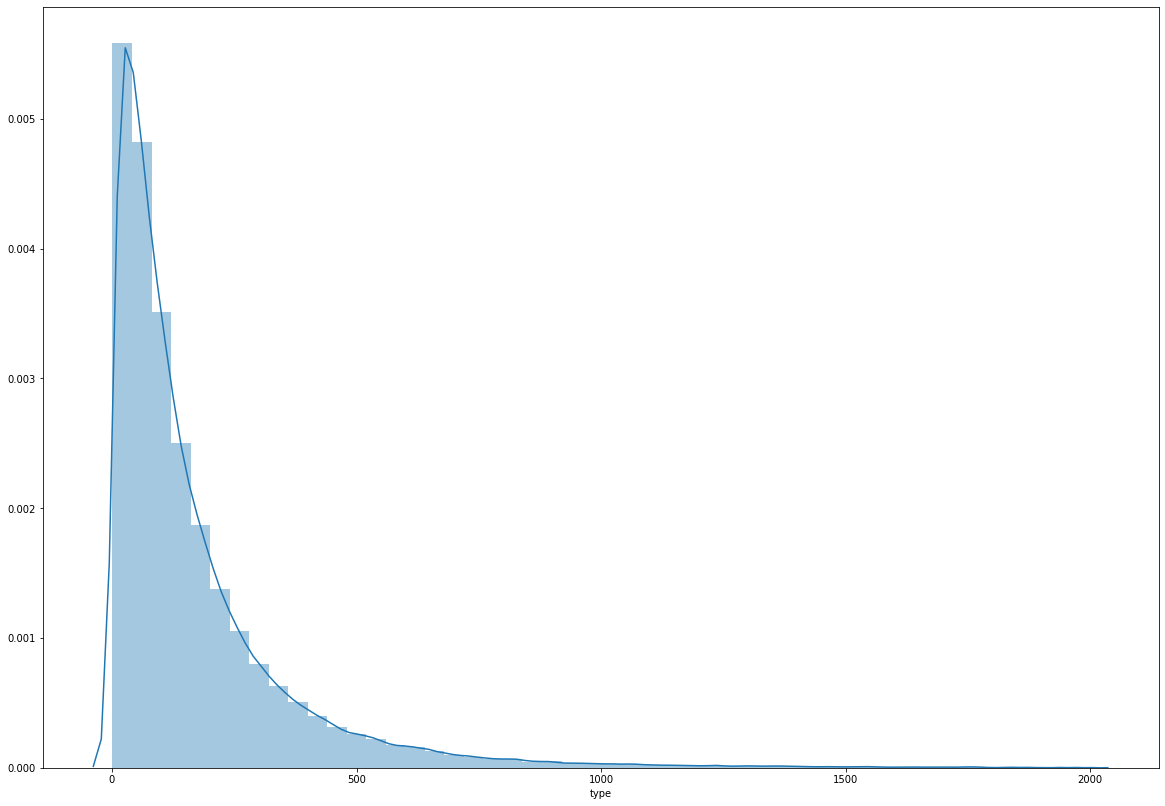

In [7]:
plt.figure(figsize=(20,14))
sns.distplot(user_action_count.loc[user_action_count.type<2000,"type"], hist=True)

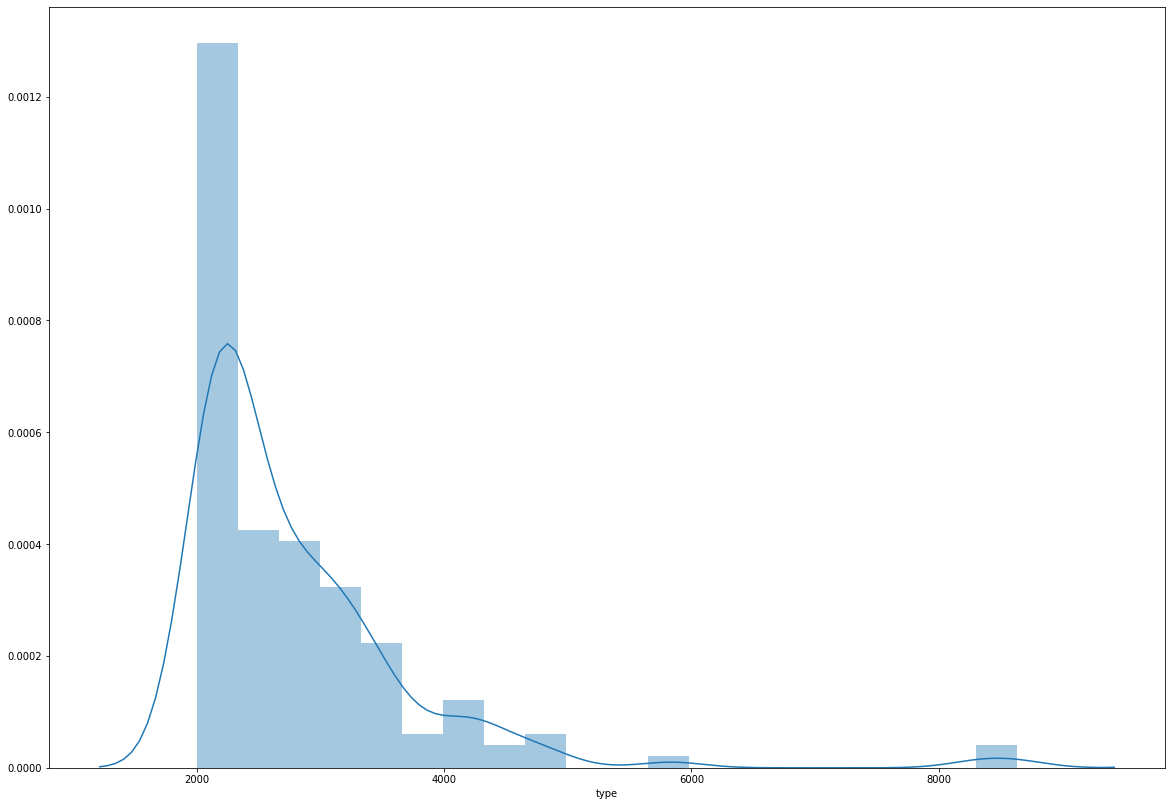

In [8]:
plt.figure(figsize=(20,14))
sns.distplot(user_action_count.loc[user_action_count.type>2000,"type"], hist=True)

用户行为数大体符合长尾分布，在长尾末端可见一些行为数极高的用户扎堆，可能存在一些特殊浏览意图（如爬虫）用户

In [28]:
# 用户各种行为计数分布
user_action_count_by_type = user_action_type.drop(columns="type",axis=1).groupby(["user_id"]).sum().reset_index()

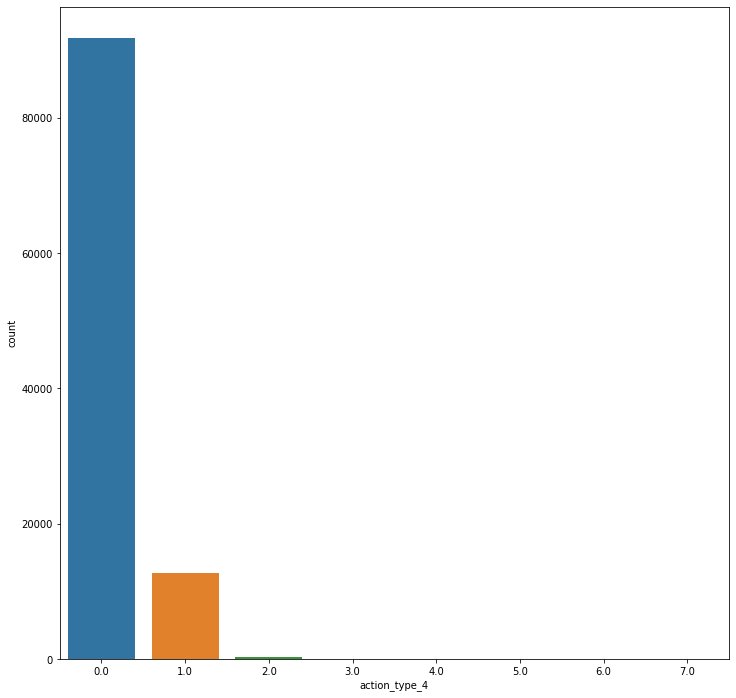

In [41]:
# 用户购买行为计数分布
plt.figure(figsize=(12,12))
sns.countplot(user_action_count_by_type.action_type_4)

In [45]:
# 购买行为发生前最近的行为发生时间
action["day_of_year"] = action["datetime"].apply(lambda x: x.dayofyear)

In [59]:
action.sort_values(["user_id","sku_id","datetime"], ascending=[1,1,0], inplace=True)

In [85]:
dif = action.groupby(["user_id","sku_id"])["day_of_year"].diff(-1)

In [89]:
action["last_action"] = dif

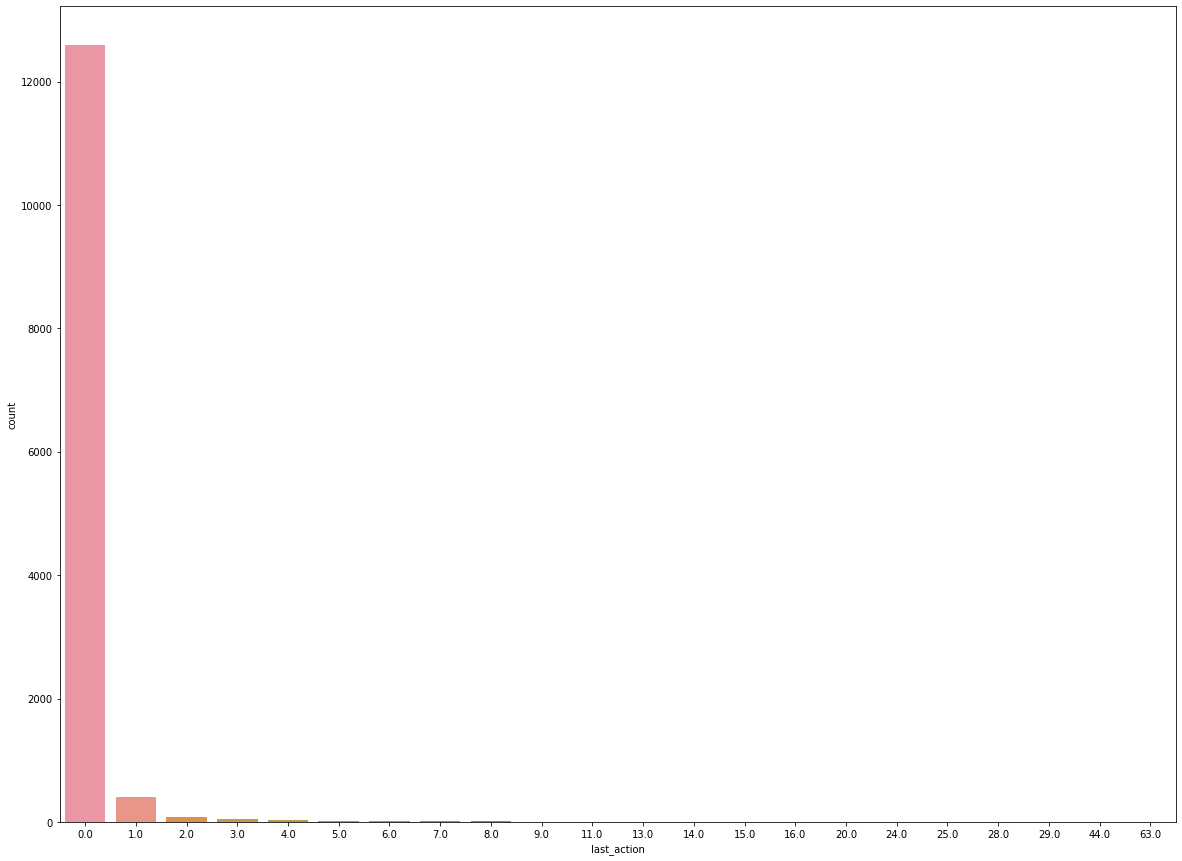

In [93]:
plt.figure(figsize=(20,15))
sns.countplot(action.loc[action.type==4,"last_action"])

In [118]:
# 复购情况
uxp_purchase_count = action.loc[action.type==4,:].groupby(["user_id","sku_id"]).agg({"type":"count"}).reset_index()

复购率:0.0042395336512983575


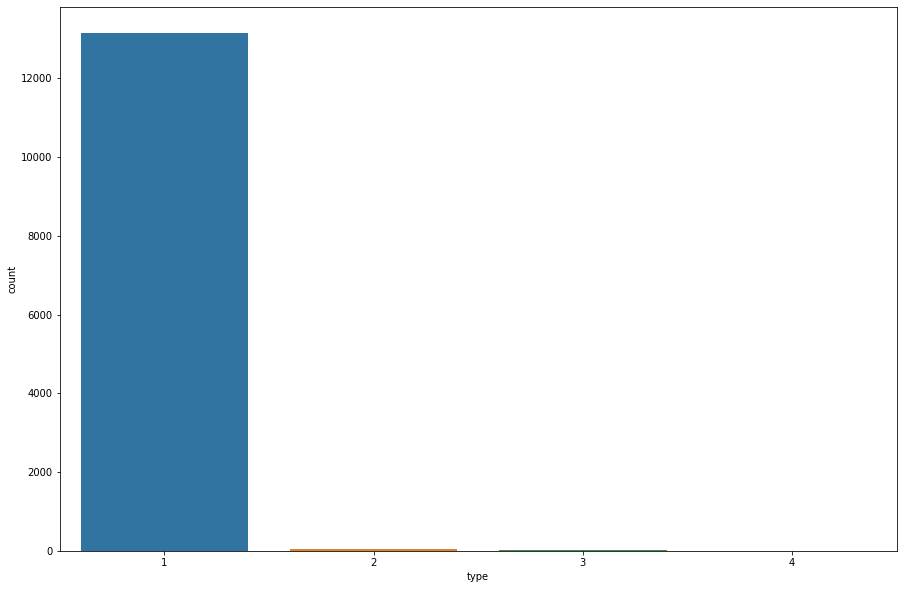

In [117]:
plt.figure(figsize=(15,10))
sns.countplot(uxp_purchase_count["type"])
c = Counter(uxp_purchase_count["type"])
print("复购率:{}".format((c[2]+c[3]+c[4])/(c[1]+c[2]+c[3]+c[4])))

可见绝大多数商品在短期不会发生复购

In [126]:
# 购买决策周期（首次行为到发生购买的时间周期）
uxp_act_buy_count = action[["user_id","sku_id","datetime","day_of_year","type"]]
uxp_act_buy_count = pd.merge(uxp_act_buy_count, uxp_purchase_count, on=["user_id","sku_id"], how="left")
uxp_act_buy_count = uxp_act_buy_count.loc[uxp_act_buy_count.type_y==1,:]

In [128]:
uxp_act_buy_count = pd.merge(uxp_act_buy_count, uxp_act_buy_count.loc[uxp_act_buy_count.type_x==4,["user_id","sku_id","day_of_year"]],\
                            on=["user_id","sku_id"], how="left")
uxp_act_buy_count

,user_id,sku_id,datetime,day_of_year_x,type_x,type_y,day_of_year_y
0,200001,20308,2016-04-13 07:41:50,104,3,1.0,87
1,200001,20308,2016-04-08 21:14:50,99,6,1.0,87
2,200001,20308,2016-04-08 21:14:50,99,6,1.0,87
3,200001,20308,2016-04-08 21:14:50,99,6,1.0,87
4,200001,20308,2016-04-08 21:14:50,99,6,1.0,87
...,...,...,...,...,...,...,...
1226810,305318,108858,2016-03-31 23:53:34,91,1,1.0,92
1226811,305318,108858,2016-03-31 23:53:34,91,6,1.0,92
1226812,305318,108858,2016-03-31 23:53:34,91,6,1.0,92
1226813,305318,108858,2016-03-31 23:53:34,91,6,1.0,92


In [129]:
uxp_act_buy_count["dist_days_buy"] = uxp_act_buy_count["day_of_year_y"] - uxp_act_buy_count["day_of_year_x"]

In [132]:
deci_days = uxp_act_buy_count.groupby(["user_id","sku_id"]).agg({"dist_days_buy":"max"})

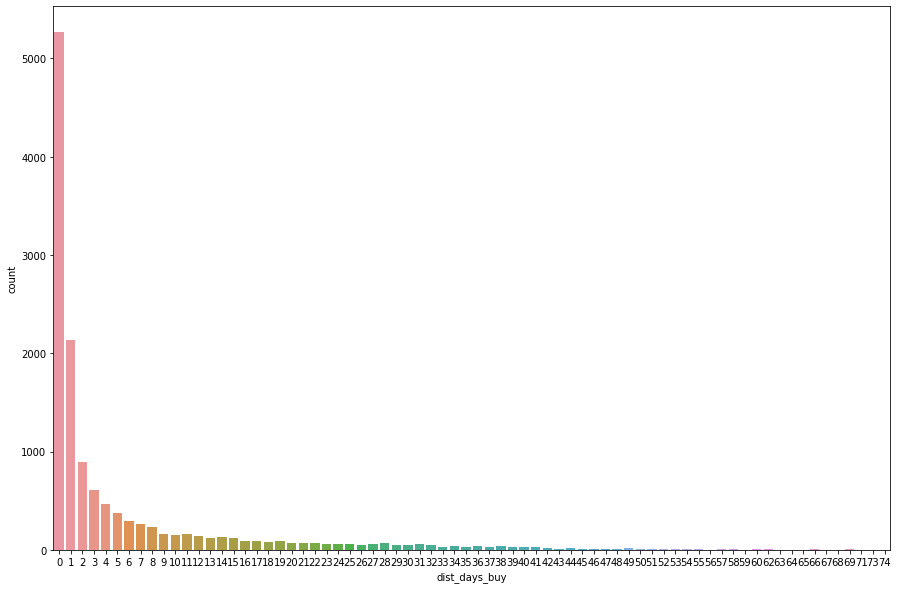

In [133]:
plt.figure(figsize=(15,10))
sns.countplot(deci_days["dist_days_buy"])

- 可见大部分购买行为的决策周期很短。
- 当天浏览当天购买的比例最高。
- 这导致大部分（user x item）购买行为没有历史行为，对历史存在交互的（user x item），预测未来一段时间是否发生购买将导致低召回